In [65]:
## Import

random_state = 1232454
from stanscofi.utils import load_dataset
from stanscofi.datasets import Dataset
from stanscofi.training_testing import traintest_validation_split, print_folds, cv_training
from stanscofi.validation import compute_metrics, plot_metrics

from glob import glob
from time import time
import sys
sys.path.insert(0,"src/")

In [58]:
## Parameters

dataset_names = ["TRANSCRIPT"]
dataset_name = dataset_names[0]

model_names=["SimplePULearning"]
model_name = model_names[0]

In [68]:
## Dataset

dataset_di = load_dataset(dataset_name, "datasets/")
dataset_di.setdefault("same_item_user_features", dataset_name=="TRANSCRIPT")
dataset_di.setdefault("name", dataset_name)
dataset = Dataset(**dataset_di)
#dataset.summary()

metric = "cityblock" 
test_size = 0.25

train_folds, test_folds, _,_ = traintest_validation_split(dataset, test_size=test_size, 
    early_stop=1, metric=metric, disjoint_users=False, verbose=False, random_state=random_state, print_dists=True)

## Prints the contents of the folds
#for sett in ["train_folds", "test_folds"]:
#    print_folds(eval(sett), dataset, sett)

train_dataset = dataset.get_folds(train_folds, dataset.name+"-train")

test_dataset = dataset.get_folds(test_folds, dataset.name+"-test")

<training_testing.traintest_validation_split> The sets of items/drugs in the training/testing datasets are disjoint.
<training_testing.traintest_validation_split> The sets of users/diseases in the training/testing datasets are *not* disjoint.
<training_testing.traintest_validation_split> Distances:
           Train set   Test set
Train set  26.583892  23.379622
Test set   23.379622  15.375953


In [77]:
## Model

#map(__import__, ["benchscofi."+model_name])
from importlib import reload
reload(benchscofi.SimplePULearning)
import benchscofi.SimplePULearning

njobs, nsplits=4, 5

start=time() 
params = {"decision_threshold": 0.5, "preprocessing_str": "same_feature_preprocessing", 
          "PI": (train_dataset.ratings_mat>0).mean().mean(), "layers_dims": [960,500,100,32,16,2], "subset": None,
         "steps_per_epoch": 1, "epochs": 50}

model = eval("benchscofi."+model_name+"."+model_name)(params)
model.fit(train_dataset)
#best_estimator = cv_training(eval("benchscofi."+model_name+"."+model_name), params, train_dataset, 
#    metric="AUC", njobs=njobs, random_state=random_state, nsplits=nsplits, show_plots=False, verbose=False) 

print("Elapsed time: %.2f sec. (njobs=%d)" % (time()-start, njobs))

#"AUC on Test %f (Train %f)" % (best_estimator["test_AUC"], best_estimator["train_AUC"])

Elapsed time: 9.41 sec. (njobs=4)


* Scores
68 unique items, 47 unique users
Scores: Min: 0.198006	Mean: 0.550121	Median: 0.553814	Max: 0.995272	Std: 0.164481

* Classification
68 unique items, 47 unique users
Positive class: 2079, Negative class: 1117

<validation.compute_metrics> Computed on #users=47, 2 ignored ( 4 perc)


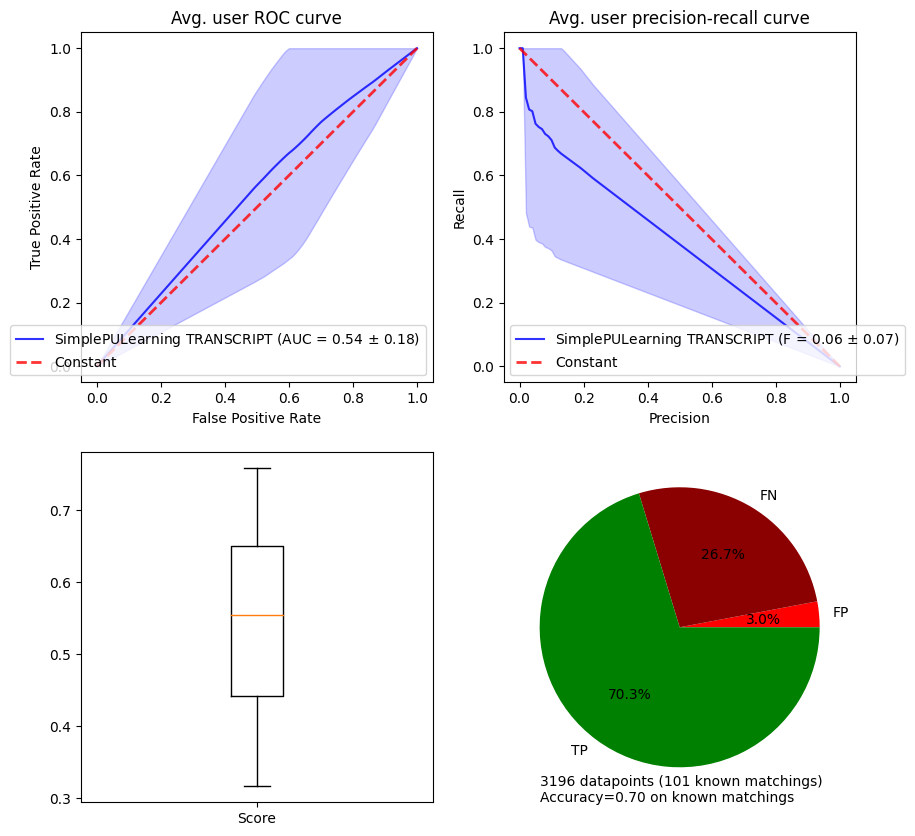

,Avg. across users,Std
AUC,0.541813,0.181808
F_1.0,0.064205,0.065661


In [78]:
scores = model.predict(test_dataset)
model.print_scores(scores)
predictions = model.classify(scores)
model.print_classification(predictions)

metrics, plot_args = compute_metrics(scores, predictions, test_dataset, beta=1,
                                                          verbose=True)
plot_metrics(**plot_args, figsize=(10,10), model_name=model.name+" "+dataset.name)

metrics

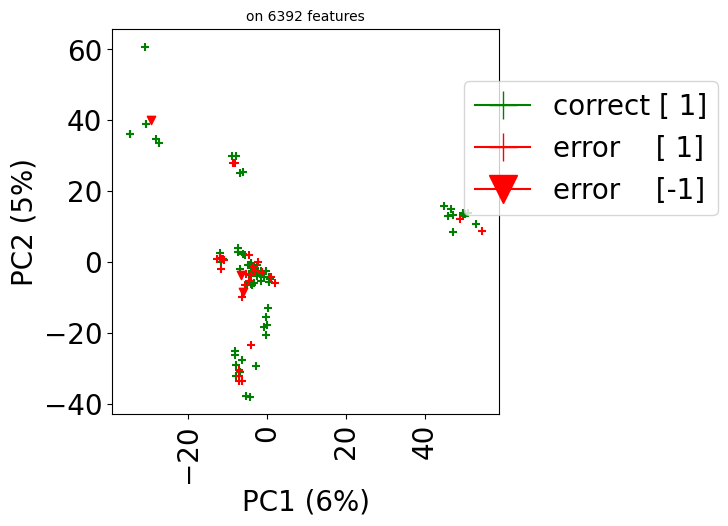

In [79]:
from copy import deepcopy
preds = deepcopy(predictions)
tmp = preds[:,0].tolist()
preds[:,0] = preds[:,1].tolist()
preds[:,1] = tmp
test_dataset.visualize(predictions=preds, show_errors=True)